In [ ]:
import sys
base_dir = 'FILTNET-for-rapidly-predicting-fibrous-filter-media-properties' # Change this to the base directory of the project
sys.path.append(f'{base_dir}/FiltNet_training')
import FiltNet as FN
from FiltNetimport load_list
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.metrics import r2_score
import pandas as pd

font_path = f'{base_dir}/timesbd.ttf'
font_properties = FontProperties(fname=font_path)

FileName = '_10066d'
Data = f'{base_dir}/HDF/FiltNet_1000d.h5'

ModelType=40
model = FN.loadmodel(f'{base_dir}/HDF/Trained/',ModelType)

#List=FN.prep(Data)
List = load_list(f'{base_dir}/list_40_10066d.h5')
TrainList, EvalList, TestList = FN.splitdata(List)

MIN,MAX=np.load(f'{base_dir}/FiltNet_training/MinMax/minmax_model40_10066d.npy')
X2_MIN,X2_MAX = np.load(f'{base_dir}/FiltNet_training/MinMax/minmax_res_model40_10066d.npy') # load voxel size minmax

In [ ]:
G=FN.gener(len(TestList),Data,TestList,MIN,MAX,X2_MIN,X2_MAX )
L=next(G)



DeeFilter output results including 14 single-value

paramters, 4 distributions

__________________________________________________

        ### Single-value parameters ###

__________________________________________________



Properties                              Value

--------------------------------------------------

Filter thickness (um)                   75.257

Mean fiber size (um)                    4.91

Fiber size SD (um)                      1.348

Porosity                                0.84

Open porosity                           0.84

Closed porosity                         0.0

Bubble point (Pa)                       18788.668

Tortuosity                              1.022

Pore size D10 (um)                      8.466

Pore size D50 (um)                      13.956

Pore size D90 (um)                      21.006

Orientation tensor x                    0.536

Orientation tensor y                    0.447

Orientation tensor z                    0.106

Delta_P at 1

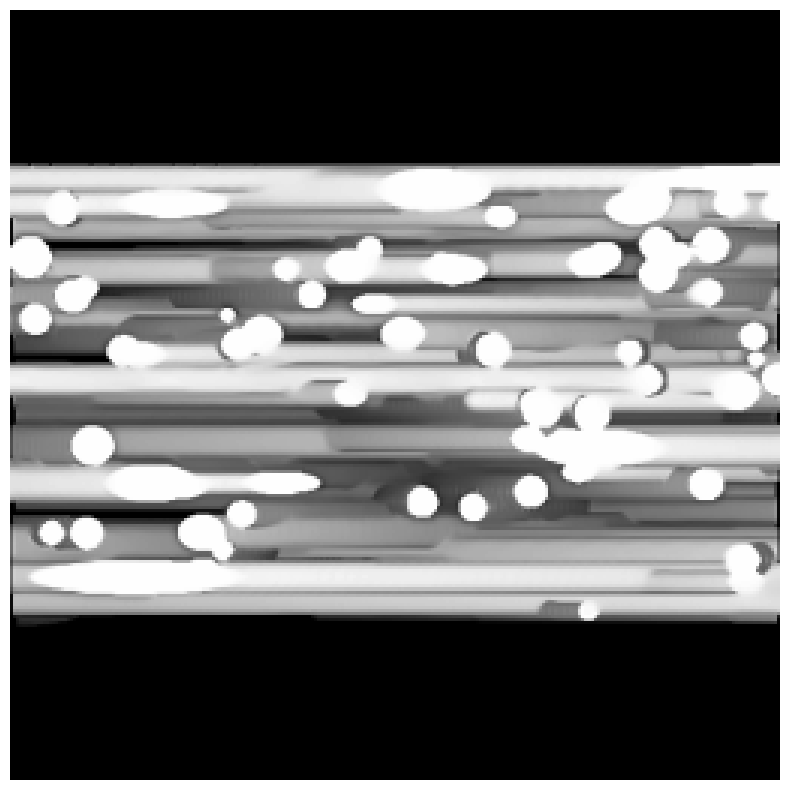

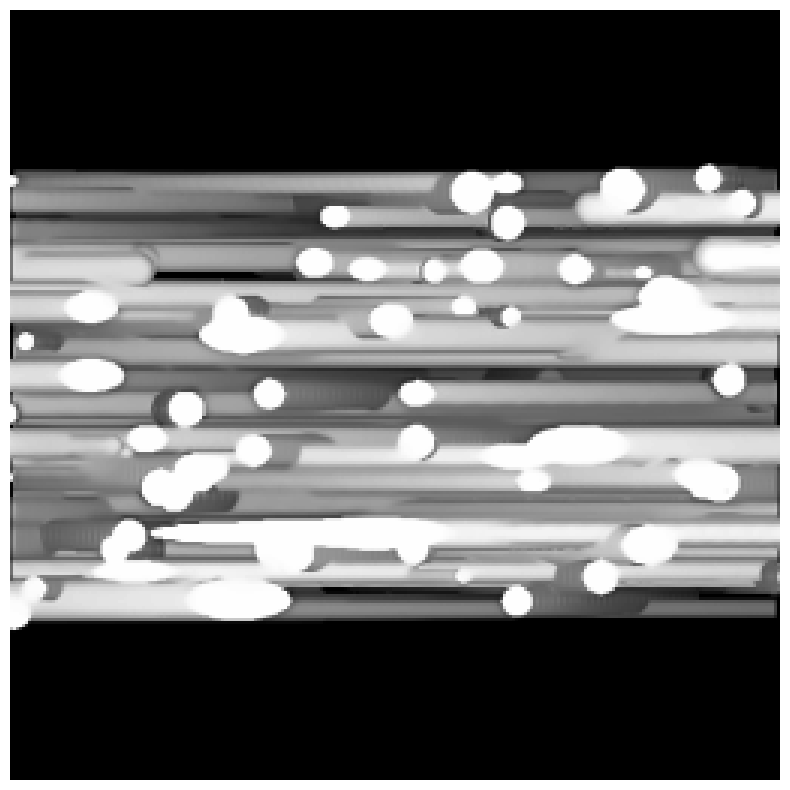

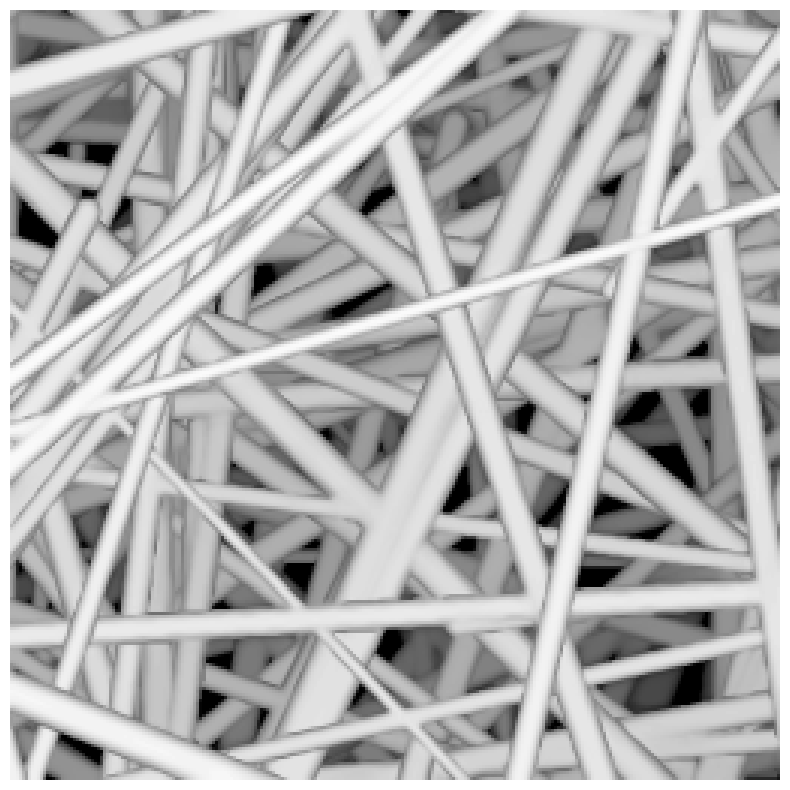

In [ ]:
Sample = 11
x=L[0]
imgs = x[0][Sample,...]
res = x[1][Sample,...]

y_Ori=L[1]

y_orientation_output = y_Ori["orientation_output"]
y_other_output = y_Ori["other_output"]
y_FFE_output = y_Ori["FFE_output"]

num_samples = y_orientation_output.shape[0]
total_cols = y_other_output.shape[1] + y_orientation_output.shape[1] + y_FFE_output.shape[1]

y = np.zeros((num_samples, total_cols), dtype=np.float32)

# Restore other_output before orientation
y[:, 0:10] = y_other_output[:, 0:10]
y[:, 10:13] = y_orientation_output
y[:, 13:-19] = y_other_output[:, 10:]
y[:, -19:] = y_FFE_output

Ref=y[Sample,...]

for i in range(imgs.shape[2]):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(1, 1, 1)
    plt.axis('off')
    ax.imshow(imgs[:,:,i],cmap='gray', vmin=0, vmax=1)
    plt.savefig(f'images/Demo3/Iamge_{i+1}.png')


all_preds = FN.predict(model,imgs,res)
FN.prettyresult(all_preds,res, f'Predictions/showcase/results_{ModelType}' + FileName + '.txt',units='um',verbose=1)

In [69]:
def Ref_values(Ref,MIN,MAX):
    unit_transfer = 1e-6
    y = Ref
    MIN=np.reshape(MIN,(1,y.shape[0]))
    MAX=np.reshape(MAX,(1,y.shape[0]))
    y=np.multiply(y,(MAX-MIN))+MIN
    y[:,0:14]=10**y[:,0:14]
    y[:,-19:]=10**y[:,-19:]
    # y[:,1]=10**y[:,1]
    y=np.mean(y,axis=0)
    val=y[0:14]
    for i in range(len(val)):
        if i in [0,1,2,7,8,9]:
            val[i]=val[i]/unit_transfer # unit tranfer from m to um
    Singles = 14
    SD_X = 50   # solidity distribution along x-axis
    SD_Z = 25   # solidity distribution along z-axis
    PSD =  200 # pore size distritbution
    FED = 19    # filtration efficiency
    d = [Singles, SD_X, SD_Z, PSD, FED]
    output=val
    for I in range(len(d)-1):
        func=y[int(np.sum(d[0:I+1])):int(np.sum(d[0:I+2]))]               
        output=np.append(output,func)
    return output

In [71]:
from matplotlib import font_manager
import matplotlib.ticker as mticker
font_manager.fontManager.addfont(font_path)
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams.update({
    'font.family': font_name,
    'font.weight': 'bold',
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 24,
})

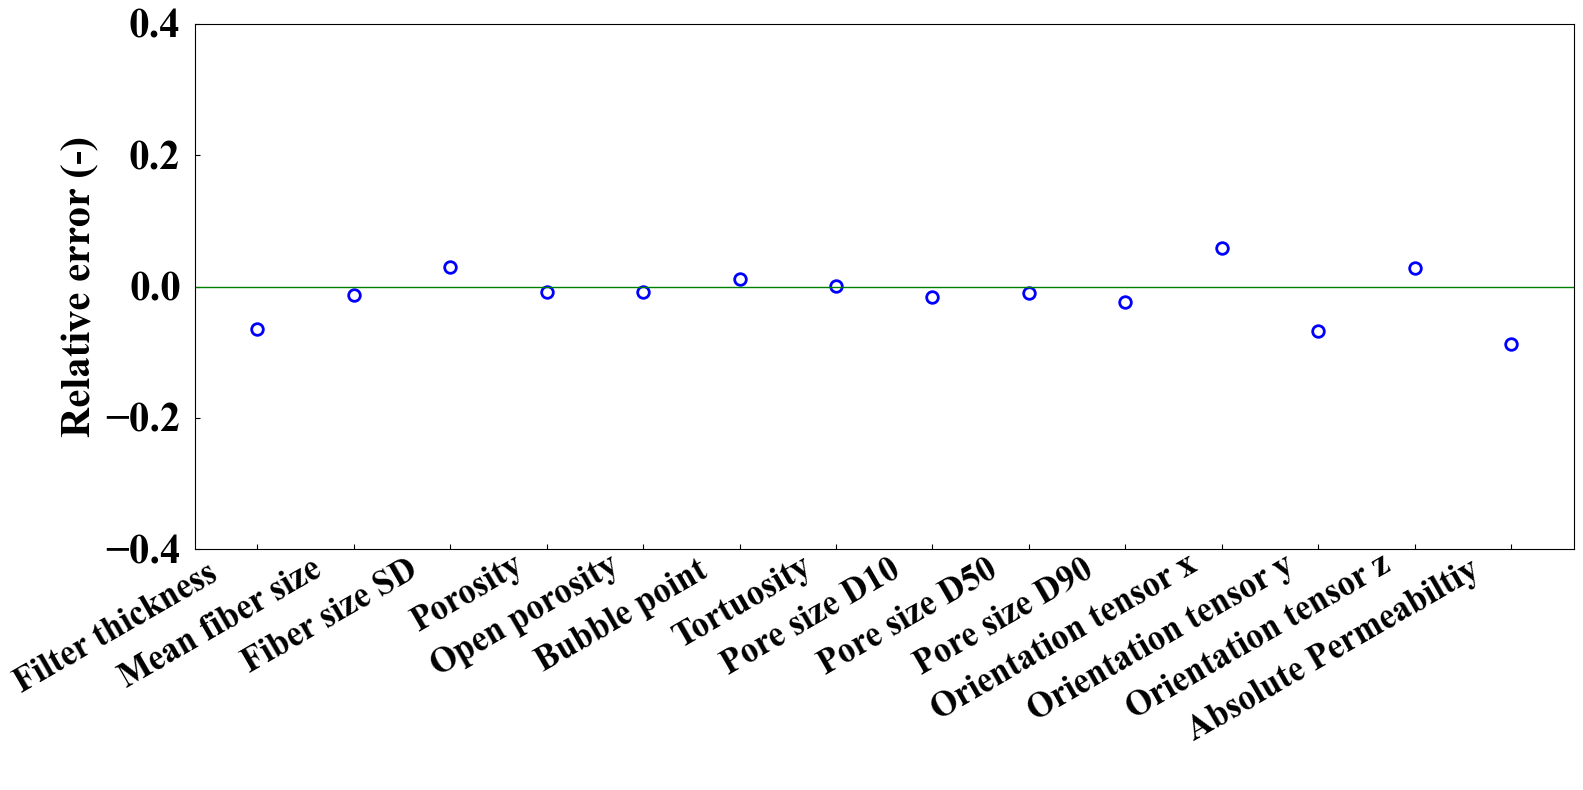

In [ ]:
# Relative_error of single feature values_version 2

Reference = Ref_values(Ref,MIN,MAX)

with open(f'{base_dir}/VarNames.txt') as f:
    VarNames = list(f)
for I in range(14):
    if "(m)" in VarNames[I]:
        VarNames[I] = VarNames[I].replace("(m)", "")
    elif "(m^2)" in VarNames[I]:
        VarNames[I] = VarNames[I].replace("(m^2)", "")
    elif "(Pa)" in VarNames[I]:
        VarNames[I] = VarNames[I].replace("(Pa)", "")
# r_error = []
# for i in range(14):
#     r1 = abs(all_preds[i] - Reference[i])/Reference[i]
#     r_error.append(r1)
#r_error = [0.09,0.04,0.39,0.01,0.01,0.09,0.00,0.04,0.05,0.09,0.02,0.02,0.16,0.05]

#scatter figure configurations
plt.figure(figsize=(16, 8))
indices = np.arange(14)
plt.scatter(indices,
            r_error, 
            color='white', 
            marker='o',
            s = 70,
            label='Abosolute relative error', 
            edgecolor='blue',
            linewidths=2)

plt.tick_params(direction="in",which="both",pad=10)
plt.ylabel('Relative error (-)',fontsize=30)
plt.xticks(ticks=indices, labels=[f'{VarNames[i]}' for i in range(14)],fontsize=25,rotation=30,ha='right')
plt.tick_params(axis='x', pad=0.5)
#plt.legend(loc='upper right',prop=font_properties,fontsize=24)

plt.ylim(-0.4, 0.4)

plt.axhline(y=0, color='green', linestyle='-', linewidth=1)


plt.savefig(f'Predictions/showcase/Relative_error of single feature values_v2.png',bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
def readDataFromTxt(file):
    # Read the text file
    file_path = file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Parse the lines to extract the data
    data = []
    for line in lines:
        line_data = line.strip().split()
        data.append(line_data)
        
    df = pd.DataFrame(data, columns=["particle size"])
    df["particle size"] = pd.to_numeric(df["particle size"])
    return df

# R^2 of Fractional filtration efficiency
Singles = 14
SD_X = 50   # solidity distribution along x-axis
SD_Z = 25   # solidity distribution along z-axis
PSD =  200 # pore size distritbution
FED = 19    # filtration efficiency
d = [Singles, SD_X, SD_Z, PSD, FED]

r2_squared = []
for I in range(len(d)-1):
    func_pre=Reference[int(np.sum(d[0:I+1])):int(np.sum(d[0:I+2]))] 
    func_ref=all_preds[int(np.sum(d[0:I+1])):int(np.sum(d[0:I+2]))]  
    r2_=r2_score(func_pre, func_ref)
    r2_squared.append(r2_)

def res_convertor(res,X2_MIN,X2_MAX):
    unit_transfer = 1e6
    pixelSize=np.multiply(res,(X2_MAX-X2_MIN))+X2_MIN
    pixelSize=10**pixelSize * 256.0 / 400.0 * unit_transfer
    return pixelSize

pixelSize = res_convertor(res,X2_MIN,X2_MAX)

print(res,pixelSize,X2_MIN,X2_MAX)

[0.7657395] [0.33999994] -7.80618 -5.80618


135.99997758865356


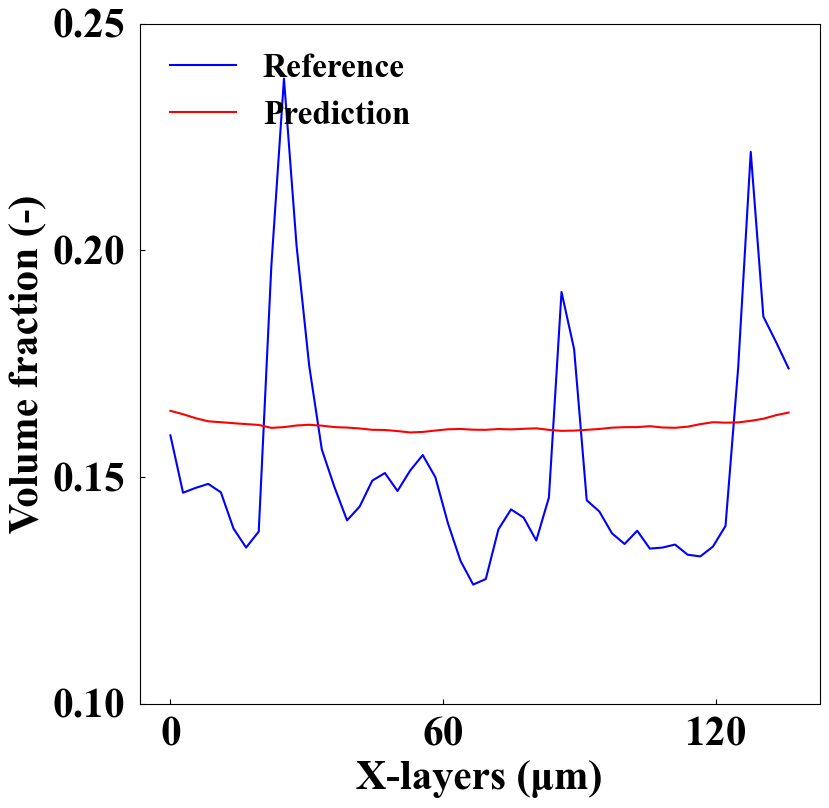

In [ ]:
# Figure of Solidity distribution (in-plane)

X_layers = np.linspace(0, 400, 50)
X_layers = X_layers * pixelSize
print(np.max(X_layers))

plt.figure(figsize=(8, 8))
r2 = r2_squared[0]
plt.plot(X_layers, Reference[int(np.sum(d[0:0+1])):int(np.sum(d[0:0+2]))],label='Reference',color='blue')
plt.plot(X_layers, all_preds[int(np.sum(d[0:0+1])):int(np.sum(d[0:0+2]))],label='Prediction',color='red')
# plt.text(0.1, 0.92, rf'$R^2$ = {r2:.2f}', ha='center', va='bottom', fontsize=16,fontproperties=font_properties,transform=plt.gca().transAxes)
plt.xlabel(f'X-layers (μm)', fontsize=30)
plt.ylabel('Volume fraction (-)', fontsize=30)
plt.tick_params(direction="in",which="both",pad=10)
plt.xticks([0, 60,120])
plt.yticks([0.10, 0.15, 0.20,0.25])
#plt.xlim(10, 1000)
#plt.ylim(0, 1)
plt.legend(loc='upper left',frameon=False)

#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplots_adjust(left=0.1,  # Adjust left margin
                    right=0.95,  # Adjust right margin
                    bottom=0.1,  # Adjust bottom margin
                    top=0.95,)  # Adjust top margin

plt.savefig(f'Predictions/showcase/Solidity distribution (in-plane).png',bbox_inches='tight', dpi=300)

plt.show() 

80.39996426524897


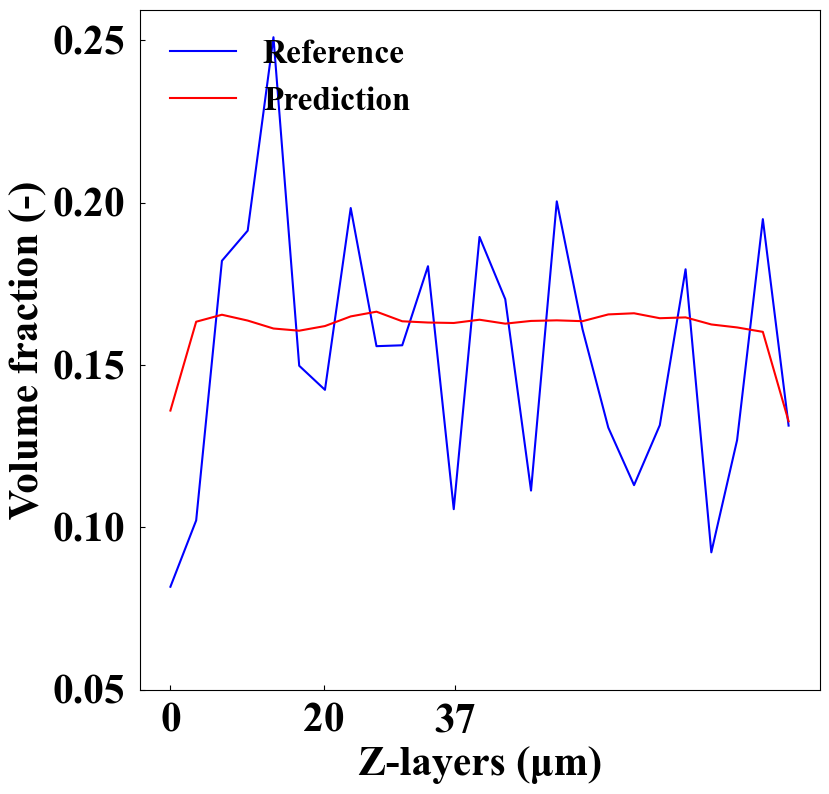

In [ ]:
# Figure of Solidity distribution (through-plane)
Thickness = Reference[0]
Z_layers = np.linspace(0, Thickness, 25)
print(np.max(Z_layers))

plt.figure(figsize=(8, 8))
r2 = r2_squared[1]
plt.plot(Z_layers, Reference[int(np.sum(d[0:1+1])):int(np.sum(d[0:1+2]))],label='Reference',color = 'blue')
plt.plot(Z_layers, all_preds[int(np.sum(d[0:1+1])):int(np.sum(d[0:1+2]))],label='Prediction',color = 'red')
# plt.text(0.1, 0.92, rf'$R^2$ = {r2:.2f}', ha='center', va='bottom', fontsize=16,fontproperties=font_properties,transform=plt.gca().transAxes)
plt.xlabel(f'Z-layers (μm)', fontsize=30)
plt.ylabel('Volume fraction (-)', fontsize=30)
plt.tick_params(direction="in",which="both",pad=10)
plt.xticks([0, 20, 37])
plt.yticks([0.05,0.10, 0.15,0.20, 0.25])
#plt.xlim(10, 1000)
#plt.ylim(0, 1)
plt.legend(loc='upper left',frameon=False)

#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.subplots_adjust(left=0.1,  # Adjust left margin
                    right=0.95,  # Adjust right margin
                    bottom=0.1,  # Adjust bottom margin
                    top=0.95,)  # Adjust top margin
plt.savefig(f'Predictions/showcase/Solidity distribution (through-plane).png',bbox_inches='tight', dpi=300)
plt.show() 

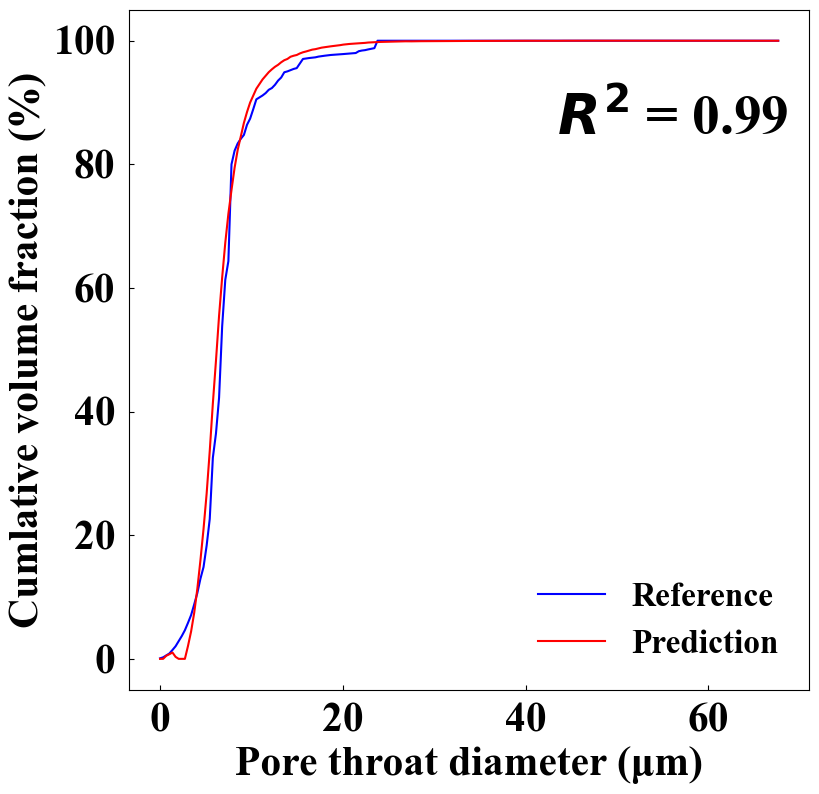

In [ ]:
# Figure of Pore size distribution (through-plane)
PoreSize = np.linspace(0, PSD-1, PSD) * pixelSize
Ref_poreSize = Reference[int(np.sum(d[0:2+1])):int(np.sum(d[0:2+2]))] * 100
Pre_poreSize = all_preds[int(np.sum(d[0:2+1])):int(np.sum(d[0:2+2]))] * 100

plt.figure(figsize=(8, 8))
r2 = r2_squared[2]
plt.plot(PoreSize, Ref_poreSize,label='Reference',color='blue')
plt.plot(PoreSize, Pre_poreSize,label='Prediction',color='red')
plt.text(0.8, 0.8, rf'$R^2$ = {r2:.2f}', ha='center', va='bottom', fontsize=40,transform=plt.gca().transAxes)
plt.xlabel(f'Pore throat diameter (μm)', fontsize=30)
plt.ylabel('Cumlative volume fraction (%)', fontsize=30)
plt.tick_params(direction="in",which="both",pad=10)
plt.legend(loc='lower right',frameon=False)

plt.subplots_adjust(left=0.1,  # Adjust left margin
                    right=0.95,  # Adjust right margin
                    bottom=0.1,  # Adjust bottom margin
                    top=0.95,)  # Adjust top margin
plt.savefig(f'Predictions/showcase/Pore size distribution.png',bbox_inches='tight', dpi=300)
plt.show() 

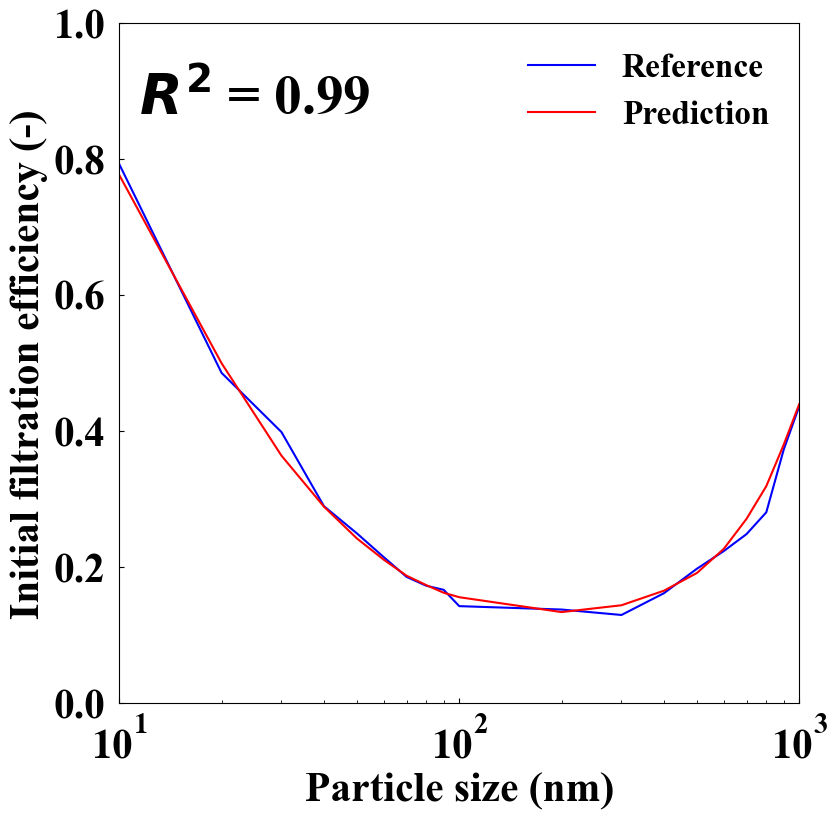

In [ ]:
# Figure of Fractional filtration efficiency
Par_Size = readDataFromTxt(f'{base_dir}\Particle_size.txt')
plt.figure(figsize=(8, 8))
r2 = r2_squared[3]
plt.plot(Par_Size, Reference[int(np.sum(d[0:3+1])):int(np.sum(d[0:3+2]))],label='Reference',color='blue')
plt.plot(Par_Size, all_preds[int(np.sum(d[0:3+1])):int(np.sum(d[0:3+2]))],label='Prediction',color='red')
plt.text(0.2, 0.85, rf'$R^2$ = {r2:.2f}', ha='center', va='bottom', fontsize=40, transform=plt.gca().transAxes)
plt.xlabel(f'Particle size (nm)', fontsize=30)
plt.ylabel('Initial filtration efficiency (-)', fontsize=30)
plt.tick_params(direction="in",which="both",pad=10)

plt.xlim(10, 1000)
plt.ylim(0, 1)
plt.legend(loc='upper right',frameon=False)

# Customize the plot to match the style in the provided figure
#plt.title('a', loc='left', fontsize=16, fontweight='bold')
plt.xscale('log')

plt.subplots_adjust(left=0.1,  # Adjust left margin
                    right=0.95,  # Adjust right margin
                    bottom=0.1,  # Adjust bottom margin
                    top=0.95,)  # Adjust top margin

plt.savefig(f'Predictions/showcase/Figure of Fractional filtration efficiency.png',bbox_inches='tight', dpi=300)
plt.show()